# Lab 6 - Wide and Deep Networks

### Eric Smith and Jake Carlson

## Introduction
For this lab, we will again be examining the Global Terrorism Database maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) at the University of Maryland. We will be looking at attacks that happened in the United States over the whole time span of the data set, since it's creation in 1974.

## Business Understanding

### Motivations
Protecting the United States from terror threats has been a major objective of the federal government. This is characterized by the founding of the Department of Homeland Security in 2001. But predicting when an attack will happen based on certain attributes is next to impossible. Attempting to train a model on the Global Terrorism Database to learn when terrorist attacks happen will result in a model that is over-trained on the GTD and will fail to predict any such attacks. Not to mention, such a system would have to be accompanied by a large-scale communication monitoring and processing system capable of feeding the model relevant inputs that exemplify a possible attack.

Instead of trying to predict when an attack will happen, our goal is to create a model that can predict the cost associate with an individual attack. Immediately after an attack has happened, law enforcement can feed in information about the attack, such as the attack type, the number of people injured, and the target type, and they could receive an approximation of the amount of property damage dealt to their city. Such a model would allow city officials and law enforcement to estimate in real time how much an attack will cost their city. Knowing the estimated cost would enable city officials to determine if they need to request support from the federal government in a shorter timeframe. Furthermore, cities could plan their future budgets accordingly to incorporate funding in response to a terrorist attack.

Cities have to submit requests to FEMA for non-disaster grants to aid in the prevention and response to terrorist activity. The Department of Homeland Security can also issue grants to aid in the prevention of terrorism. Grant policies start with Congress allocating funds for federal grants of this type. The Executive Branch provides input for how the policy should be implemented. Then grant issuing agencies develop their own policies for how to allocate grant money.

Each state defines their own thresholds for when an attack is severe enough that they will ask for federal assistance. Our model will allow officials to immediately decide if they need to file for a federal grant. Smaller cities have lwoer thresholds and larger cities can handle higher costs before needing assistance.

### Objectives
Based on the characteristics of an attack, such as the target type and the date, we want to assign an estimated cost label to the entity. Because our system will be used to estimate the cost for local city governements, perfect classification of cost is not required. However, it is important that these estimations are accurate because a request for a grant will need to be formed and sent to the federal government.

Based on the distribution of our classes we want to achieve an accuracy that is greater than the ratio of the majority class to the rest of the population. The class counts are given by:

    Catastrophic (class 0): 4
    Major (class 1): 88
    Minor (class 2): 5871
    Unknown (class 3): 1655

The majority class is class 2, which constitutes 87% of the data set. We want to achieve a classification accuracy greater than this for our model to be useful.

### Evaluation ** REDO
Because we are predicting the group that conducted the attack, it would be an issue if we predicted the wrong group. Law enforcement could waste time and resources following the incorrect prediction and the perpetrators would have more time to get away or plan another attack. We will evaluate our model using the precision score in order to minimize the false positive rate. We will use macro precision so all of the groups are weighted equally.

Because some of the groups are over-represented, we will use stratified 10-fold cross validation so the classes in each fold match the distribution of the original data set. Running training and testing ten times will also allow us to be confident in the generalization performance of the model.

## Data Preparation

### Attributes
Here is the list of attributes we will keep in our data set to use for classification.

#### General Information
- **iyear** (ordinal): The year the event occured in
- **imonth** (ordinal): The month the event occured in
- **iday** (ordinal): The day the event occured in
- **extended** (binary): 1 if the incident was longer than 24 hours, 0 otherwise
    - **resolution** (ordinal): The date an extended incident was resolved if *extended* is 1


- **inclusion criteria** (binary): There are three inclusion criteria where a 1 indicates the event meets that criteria
    - **crit1**: Political, economic, religious, or social goal
    - **crit2**: Intention to coerce, intimidate, or publicize
    - **crit3**: Outside international humanitarian law


#### Location
We will provide the name of the city to the model. An alternative method would be to train a unique logistic regression algorithm for each city where our system is deployed.
- **city** (text): Name of the city in which the event occured
- **vicinity** (nominal/binary): A 1 indicates the event occured in the immediate vicinity of *city*, 0 indicates the even occured in *city*
- **latitude** (ratio): The latitude of the *city* in which the event occured
- **longitude** (ratio): The longitude of the *city* in which the event occured

#### Attack Type
The most severe method of attack. This will be our class label. Although the original data set contains columns for three different attack types, the attack types are ranked by their severity. Many attacks only have one attack type. By removing the second and third attack types from our data set, we will still be predicting the most severe of the attack types.
- **attacktype1** (ordinal): Most severe attack type

- The attack types follow the following hierarchy:
    1. Assassination
    2. Armed Assault
    3. Bombing/Explosion
    4. Hijacking
    5. Barricade Incident
    6. Kidnapping
    7. Facility/Infrastructure Attack 
    8. Unarmed Assault
    9. Unknown


- **suicide** (nominal/binary): A 1 indicates there was evidence the attacker did not make an effort to escape with their life

#### Target Type
We will only be considering the first target type of the attack. The set of target attributes is provided below:
- **targtype1, targtype1_txt** (nominal): The general type of target from the following list:
    1. Business
    2. Government (General)
    3. Police
    4. Military
    5. Abortion related
    6. Airports and aircraft
    7. Government (Diplomatic)
    8. Educational institution
    9. Food or water supply
    10. Journalists and media
    11. Maritime
    12. NGO
    13. Other
    14. Private citizens and property
    15. Religious figures and institutions
    16. Telecommunication
    17. Terrirists and non-state militias
    18. Tourists
    19. Transportation
    20. Unknown
    21. Utilities
    22. Violent political parties
    

- **targsubtype1, targsubtype1_txt** (nominal): There are a number of subtypes for each of the above target types

#### Perpetrator Information
The data set provides information on up to three perpetrators if the attack was conducted by multiple groups. We will only be considering the first group, or the one decided to have the most responsibility for the attack.
- **individual** (binary): A 1 indicates the individuals carrying out the attack are not affiliated with a terror organization
- **nperps** (ratio): Indicates the total number of terrorists participating in the event
- **nperpcap** (ratio): Number of perpatrators taken into custody
- **claimed** (binary): A 1 indicates a person or group claimed responsibility for the attack
- **claimmode** (nominal): Records the method the terror group used to claim responsibility for the attack. Can be one of the ten following categories:
    1. Letter
    2. Call (post-incident)
    3. Call (pre-incident)
    4. E-mail
    5. Note left at scene
    6. Video
    7. Posted to website
    8. Personal claim
    9. Other
    10. Unknown


#### Casualties and Consequences
- **nkill** (ratio): Records the number of confirmed kills for the incident
- **nkillter** (ratio): Indicates the number of terrorists who were killed in the event
- **nwound** (ratio): Indicates the number of people who sustained non-fatal injuries in the event
- **nwoundte** (ratio): Indicates the number of terrorists who sustained non-lethal injuries
- **property** (binary): A 1 indicates the event resulted in property damage. We will only select entities that resulted in property damage
- **propextent** (ordinal): If *property* is a 1, this field records the extent of the property damage following the scheme:
    <ol start='0'>
        <li>Catastrophic (likely > \$1 billion)</li>
        <li>Major (likely > \$1 million and < \$1 billion)</li>
        <li>Minor (likely < \$1 million)</li>
        <li>Unknown</li>
    </ol>

### Data Cleaning
We will clean the data set so only the above attributes are present.

In [2]:
import pandas as pd

df = pd.read_csv('./data/After_911.csv', encoding='ISO-8859-1')

# drop rows without property damage or unknown city
orig_len = df.shape[0]
df = df[df['property'] == 1]
df = df[df['city'] != "Unknown"]
new_len = df.shape[0]
print("Percent maintained: ", new_len/orig_len*100, "%")

# select columns of interest
df = df[['iyear', 'imonth', 'iday', 'extended', 'country_txt', 'city', 'vicinity',
         'latitude', 'longitude', 'crit1', 'crit2', 'crit3', 'success', 'suicide',
         'attacktype1_txt', 'targtype1_txt', 'individual', 'nperps', 'nperpcap', 
         'claimed', 'claimmode', 'nkill', 'nkillter', 'nwound', 
         'nwoundte', 'propextent', 'ishostkid', 'nhostkid', 'nreleased']]

import numpy as np
from sklearn import preprocessing
from datetime import datetime

logical_cols = ['extended', 'vicinity', 'crit1', 'crit2', 'crit3',
                'success', 'suicide', 'individual', 'claimed', 'ishostkid']
categorical_cols_txt = ['attacktype1_txt', 'targtype1_txt', 'country_txt', 'city']
categorical_cols_int = ['claimmode']
ratio_cols = ['latitude', 'longitude', 'nperps', 'nperpcap', 'nkill',
              'nkillter', 'nwound', 'nwoundte', 'nhostkid', 'nreleased']

# replace unknowns with nan
logical_replace = dict((l, {-9:np.nan}) for l in ['claimed'])
ratio_replace = dict((r, {-99:np.nan, -9:np.nan}) for r in ratio_cols)
df.replace(to_replace=logical_replace, inplace=True)
df.replace(to_replace=ratio_replace, inplace=True)

# replace NA city with mode city for country
df['city'] = df.groupby('country_txt')['city'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['latitude'] = df.groupby('country_txt')['latitude'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['longitude'] = df.groupby('country_txt')['longitude'].transform(lambda x: x.fillna(x.mode().iloc[0]))
# for c in df.country.values:
#     df[df.country == c].fillna()

# replace NA's with median for col
df.fillna(value=df.median(), inplace=True)

# convert logical cols to bools
for l in logical_cols:
    df[l] = df[l].astype('bool')

# normalize ratio cols
min_max_scaler = preprocessing.MinMaxScaler()
df[ratio_cols] = min_max_scaler.fit_transform(df[ratio_cols])

# standardize date attributes
# use year, month, and day to get day number in year
day_list = []
for r in df[['iyear', 'imonth', 'iday']].iterrows():
    # fudge day 0 to 1
    if r[1].iday == 0:
        day_list.append(
            datetime(r[1].iyear, r[1].imonth, 1).timetuple().tm_yday)
    else:
        day_list.append(
            datetime(r[1].iyear, r[1].imonth, r[1].iday).timetuple().tm_yday)
        
df = df.assign(dayn=day_list)

# drop month and day attributes
df.drop(['imonth', 'iday'], axis=1, inplace=True)

# normalize day number and year col
df['iyear'] = df['iyear'].astype(np.float64)
df['dayn'] = df['dayn'].astype(np.float64)
df[['iyear', 'dayn']] = min_max_scaler.fit_transform(df[['iyear', 'dayn']])

# convert categorical cols as ints
for c in categorical_cols_int:
    df[c] = df[c].astype(np.int64)

encoders = {}
# one-hot encode categorical cols
for c in categorical_cols_txt:
    encoders[c] = preprocessing.LabelEncoder()
    df[c+'_int'] = encoders[c].fit_transform(df[c])
    categorical_cols_int.append(c+'_int')

# zero-index propextent
df.propextent = df.propextent - 1

df.head()

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Percent maintained:  36.354092102123595 %


,iyear,extended,country_txt,city,vicinity,latitude,longitude,crit1,crit2,crit3,...,nwoundte,propextent,ishostkid,nhostkid,nreleased,dayn,attacktype1_txt_int,targtype1_txt_int,country_txt_int,city_int
3,0.0,False,United States,New York City,False,0.758239,0.161304,True,True,True,...,0.0,0.0,True,0.095499,0.000000,0.000000,4,13,99,2171
4,0.0,False,United States,New York City,False,0.758239,0.161304,True,True,True,...,0.0,0.0,True,0.063666,0.000000,0.000000,4,13,99,2171
5,0.0,False,United States,Arlington,False,0.740602,0.150956,True,True,True,...,0.0,0.0,True,0.063666,0.000000,0.000000,4,6,99,183
6,0.0,False,United States,Shanksville,True,0.751555,0.144956,True,True,True,...,0.0,0.0,True,0.042810,0.000000,0.000000,4,13,99,2724
10,0.0,False,Italy,Palermo,False,0.733236,0.452702,True,True,True,...,0.0,2.0,False,0.003293,0.001256,0.017857,0,12,46,2281


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618 entries, 3 to 20953
Data columns (total 32 columns):
iyear                  7618 non-null float64
extended               7618 non-null bool
country_txt            7618 non-null object
city                   7618 non-null object
vicinity               7618 non-null bool
latitude               7618 non-null float64
longitude              7618 non-null float64
crit1                  7618 non-null bool
crit2                  7618 non-null bool
crit3                  7618 non-null bool
success                7618 non-null bool
suicide                7618 non-null bool
attacktype1_txt        7618 non-null object
targtype1_txt          7618 non-null object
individual             7618 non-null bool
nperps                 7618 non-null float64
nperpcap               7618 non-null float64
claimed                7618 non-null bool
claimmode              7618 non-null int64
nkill                  7618 non-null float64
nkillter               76

In [4]:
# save full clean data set
df.to_csv('./clean-data/After_911_clean.csv', sep=',')

We have done a number of things to prepare our data for modeling. First, we replaced unknown values in each column with the median for that column. Second, we converted attributes that encode a logical value to a boolean. Third, we normalized the ratio attributes so they are all in the range 0 to 1. Fourth, we convert the year, month, and day attribute to a single numeric attribute which represents the day number in the year that the attack occured on. Then we drop the month and day columns. We still want the year attribute because of the change in attack frequency we noticed in Lab 1, so we standardize the year and day number columns. Finally, we one-hot encode all of the categorical attributes in our data set, creating a variety of additional columns that are needed to represent our data in this way.

### Crossed Columns
We will create several crossed columns to make the data set wider. This will help our model with memorization of the training data. We will cross attack type with property extent, target type, city, and country. We will also cross property extent with target type.

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('./clean-data/After_911_clean.csv', index_col=0)

logical_cols = ['extended', 'vicinity', 'crit1', 'crit2', 'crit3',
                'success', 'suicide', 'individual', 'claimed', 'ishostkid']
categorical_cols_txt = ['attacktype1_txt', 'targtype1_txt', 'country_txt', 'city']
categorical_cols_int = ['claimmode'] + [x+'_int' for x in categorical_cols_txt]
ratio_cols = ['latitude', 'longitude', 'nperps', 'nperpcap', 'nkill',
              'nkillter', 'nwound', 'nwoundte', 'nhostkid', 'nreleased']
feature_cols = logical_cols + categorical_cols_int + ratio_cols

y = df['propextent']
X = df.drop(['propextent'], axis=1)
y_ints = y.values

df.head()

,iyear,extended,country_txt,city,vicinity,latitude,longitude,crit1,crit2,crit3,...,nwoundte,propextent,ishostkid,nhostkid,nreleased,dayn,attacktype1_txt_int,targtype1_txt_int,country_txt_int,city_int
3,0.0,False,United States,New York City,False,0.758239,0.161304,True,True,True,...,0.0,0.0,True,0.095499,0.000000,0.000000,4,13,99,2171
4,0.0,False,United States,New York City,False,0.758239,0.161304,True,True,True,...,0.0,0.0,True,0.063666,0.000000,0.000000,4,13,99,2171
5,0.0,False,United States,Arlington,False,0.740602,0.150956,True,True,True,...,0.0,0.0,True,0.063666,0.000000,0.000000,4,6,99,183
6,0.0,False,United States,Shanksville,True,0.751555,0.144956,True,True,True,...,0.0,0.0,True,0.042810,0.000000,0.000000,4,13,99,2724
10,0.0,False,Italy,Palermo,False,0.733236,0.452702,True,True,True,...,0.0,2.0,False,0.003293,0.001256,0.017857,0,12,46,2281


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618 entries, 3 to 20953
Data columns (total 32 columns):
iyear                  7618 non-null float64
extended               7618 non-null bool
country_txt            7618 non-null object
city                   7618 non-null object
vicinity               7618 non-null bool
latitude               7618 non-null float64
longitude              7618 non-null float64
crit1                  7618 non-null bool
crit2                  7618 non-null bool
crit3                  7618 non-null bool
success                7618 non-null bool
suicide                7618 non-null bool
attacktype1_txt        7618 non-null object
targtype1_txt          7618 non-null object
individual             7618 non-null bool
nperps                 7618 non-null float64
nperpcap               7618 non-null float64
claimed                7618 non-null bool
claimmode              7618 non-null int64
nkill                  7618 non-null float64
nkillter               76

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical

col_names = X.columns.values

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=64)
for train_idx, test_idx in sss.split(X.values, y.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
#     X_cat_train, X_cat_test = pd.DataFrame(X[categorical_cols_int].values[train_idx], columns=categorical_cols), pd.DataFrame(df_categories.values[test_idx], columns=categorical_cols)
    y_train, y_test = pd.DataFrame(y.values[train_idx], columns=["propextent"]), pd.DataFrame(y.values[test_idx], columns=["propextent"])

# X_train, X_test = X_train.values, X_test.values
y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import recall_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier

def build_model():
    model = Sequential()
    model.add(Dense(120, input_dim=input_dim, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(output_dim=4, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = X_train[feature_cols].values.shape[1]
model = build_model()
model.summary()

model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
results = cross_val_score(model, X_train[feature_cols].values, y_train, cv=kfold)

print(results.mean())

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=4)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120)               3120      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4840      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 164       
Total params: 8,124
Trainable params: 8,124
Non-trainable params: 0
_________________________________________________________________
0.632293013471


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

cross_columns = [['attacktype1_txt','targtype1_txt'],
                 ['attacktype1_txt','city'],
                 ['attacktype1_txt','country_txt']]

embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()

    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)

    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )

    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32',name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

wide_branch = concatenate(all_branch_outputs)

all_branch_outputs = []
# add in the embeddings
for col in categorical_cols_int:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )

    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the ratio features
all_inputs.append(Input(shape=(X_train[feature_cols].values.shape[1],),sparse=False))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep_branch = concatenate(all_branch_outputs)
deep_branch = Dense(units=50,activation='relu')(deep_branch)
deep_branch = Dense(units=10,activation='relu')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch])
final_branch = Dense(units=4,activation='softmax')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

# model.summary()

model.compile(optimizer='adagrad',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train_final = X_ints_train
X_train_final.append(X_train[feature_cols].values)

# X_train_stacked = X_train_final[0].reshape((6856,1))
# for i in range(1,len(X_train_final)):
#     print(i)
#     print(X_train_stacked.shape)
#     print(X_train_final[i].shape)
#     X_train_stacked = np.hstack((X_train_stacked, X_train_final[i].reshape((6856,1))))
#     print(X_train_stacked.shape)
# X_train_stacked = np.hstack((X_train_stacked, X_train[feature_cols].values))


# model = KerasClassifier(build_fn=model, epochs=10, batch_size=32, verbose=0)
# kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
# # results = cross_val_score(model, X_ints_train+X_train[feature_cols].values, y_train, cv=kfold)
# results = cross_val_score(model, X_train_stacked, y_train, cv=kfold)

accuracies = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train[feature_cols], y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = [X[train_idx] for X in X_train_final]
    y_train_temp = y_train[train_idx]
    X_test_temp = [X[test_idx] for X in X_train_final]
    y_test_temp = y_train[test_idx]

    # fit on train and predict on test
    model.fit(X_train_temp, y_train_temp, epochs=10, batch_size=32, verbose=0)
    pred = np.argmax(model.predict(X_test_temp), axis=1)
    
    # take accuracy score
    accuracies.append(accuracy_score(y_test_temp, pred))

print(accuracies)
# model.fit(X_train_final,
#           y_train, epochs=10, batch_size=32, verbose=0)

[0.77900874635568518, 0.87339556592765466, 0.89381563593932323, 0.87915936952714535]


In [10]:
X_test_final = X_ints_test
X_test_final.append(X_test[feature_cols].values)

pred = np.argmax(model.predict(X_test_final), axis=1)
print(accuracy_score(y_test, pred))

0.778215223097


In [11]:
from sklearn.neural_network import MLPClassifier
sk_mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                       solver='lbfgs', 
                       learning_rate_init=0.01, 
                       max_iter=120, 
                       random_state=1)

In [20]:
accuracies = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train[feature_cols], y_train):
    # fit on train and predict on test
    sk_mlp.fit(X_train[feature_cols], y_train)
    pred = np.argmax(sk_mlp.predict(X_test[feature_cols]), axis=1)
    
    # take accuracy score
    accuracies.append(accuracy_score(y_test, pred))

print(accuracies)

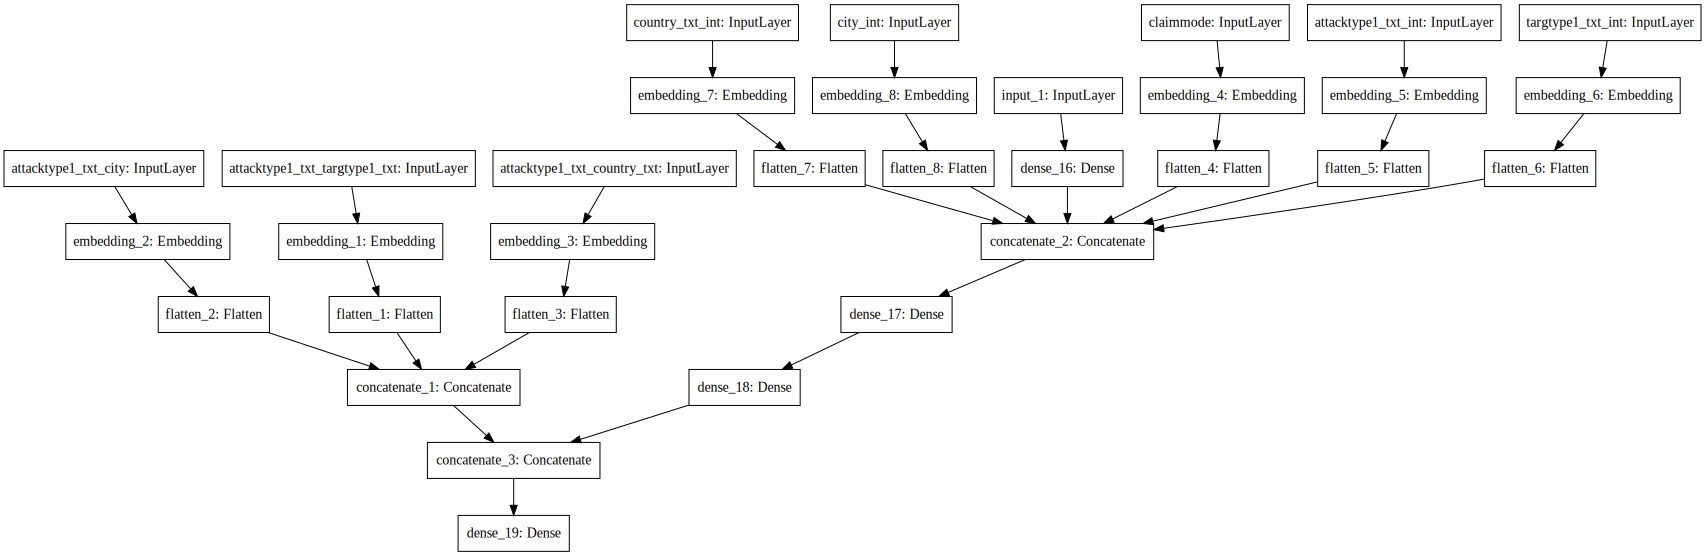

In [19]:
from IPython.display import SVG
import pydot
import graphviz
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))